# This notebook gives a way of calibrating a stereo camera system based on a single image pair

#### Imports

In [57]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

#### Read images and define chessboard pattern

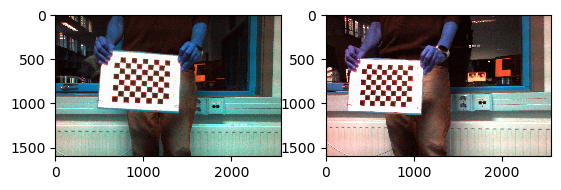

In [43]:
# Load images
im_left = cv.imread("left.jpg")
im_right = cv.imread("right.jpg")


# Define pattern
pattern_shape = (7, 9)  # Works with (5, 6) and (7, 9)
shape_size = (0.02, 0.02)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((pattern_shape[0]*pattern_shape[1],3), np.float32)
objp[:,:2] = np.mgrid[0:(pattern_shape[0]-1)*shape_size[0]*1.01:shape_size[0],0:(pattern_shape[1]-1)*shape_size[1]*1.01:shape_size[1]].T.reshape(-1,2)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_left)
ax[1].imshow(im_right)


In [55]:
# Find camera pose from a single image, relative to the chessboard
def calibrate_single_img(image, camera_matrix=None, dist=None):
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    gray = cv.cvtColor(image.copy(), cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, pattern_shape, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        #imgp = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
 
        if camera_matrix:
            # JUst PnP problem
            ret, rvec, tvec = cv.solvePnP(opjp, corners, camera_matrix, dist, flags=0)
            return True, {"K": camera_matrix, "rvec": rvec, "tvec": tvec}
        else:            
            ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera([objp], [corners], gray.shape[::-1], None, None)
            
            h,  w = image.shape[:2]
            newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
            
            return True, {"K": newcameramtx, "rvec": rvecs[0], "tvec": tvecs[0]}
 
    else:
        print("Could not extract corners!")

        return False, {"K": camera_matrix, "rvec": None, "tvec": None}

#### Get the individual camera parameters

In [64]:
# Left cam
ret, left_params = calibrate_single_img(im_left)
left_rvec = left_params['rvec']
R_left = Rotation.from_rotvec(left_rvec.flatten(), degrees=False).as_matrix()
t_left = left_params['tvec']
T_left = np.eye(4)
T_left[:3, :3] = R_left
T_left[:3, 3] = t_left.flatten()

print("Left cam transformation:\n", T_left)

# Right cam
ret, right_params = calibrate_single_img(im_right)
right_rvec = right_params['rvec']
R_right = Rotation.from_rotvec(right_rvec.flatten(), degrees=False).as_matrix()
t_right = right_params['tvec']
T_right = np.eye(4)
T_right[:3, :3] = R_right
T_right[:3, 3] = t_right.flatten()


print("\nRight cam transformation:\n", T_right)

Left cam transformation:
 [[ 0.04308902  0.9877455  -0.15000718 -0.17038951]
 [-0.9935081   0.05818626  0.09775484 -0.01104127]
 [ 0.10528526  0.14482119  0.98384035  1.37080175]
 [ 0.          0.          0.          1.        ]]

Right cam transformation:
 [[ 0.03868548  0.99911223 -0.01667917 -0.27516013]
 [-0.99775273  0.03953592  0.05409629  0.09254355]
 [ 0.05470769  0.01454894  0.99839641  0.78112293]
 [ 0.          0.          0.          1.        ]]


#### Find transformation between cameras

In [81]:
T_RL = T_right @ np.linalg.inv(T_left)
print("Transformation from left to right camera frame:\n", T_RL)

R_RL = Rotation.from_matrix(T_RL[:3, :3])
euler_RL = R_RL.as_euler('xyz', degrees=True)
print("\nThe relative rotations between left and right cameras are:", euler_RL, "degrees")

t_RL = T_RL[:3, 3]
print("\nThe relative translation between left and right cameras are:", t_RL, "meters")

Transformation from left to right camera frame:
 [[ 0.99103752  0.01806979  0.132356   -0.28753206]
 [-0.01205558  0.99886404 -0.04610091  0.16471334]
 [-0.13303868  0.0440921   0.99012959 -0.59833   ]
 [ 0.          0.          0.          1.        ]]

The relative rotations between left and right cameras are: [ 2.54979099  7.64522153 -0.69694634] degrees

The relative translation between left and right cameras are: [-0.28753206  0.16471334 -0.59833   ] meters


#### Visualize stereo baseline

(-0.014031545130131738, 0.29466244773276645) (-0.10517072866120802, 0.17262717380871795) (-1.455092591424331, 0.06929012340115862)
1.5243827148254896


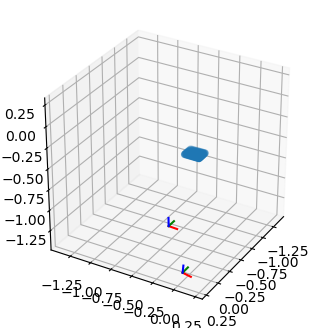

In [136]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

def draw_frame(ax, T):
    origin = -T[:3, 3].flatten()
    cam_base = T[:3, :3] @ np.eye(3)*0.1
    
    colors = ['r', 'g', 'b']
    for i, base_vector in enumerate(cam_base):
        end_point = (origin + base_vector).flatten()
        ax.plot([origin[0], end_point[0]], [origin[1], end_point[1]], [origin[2], end_point[2]], c=colors[i])
    
draw_frame(ax, T_left)
draw_frame(ax, T_right)


# Draw checkerboard
ax.scatter(objp[:, 0], objp[:, 1], objp[:, 2])

ax.view_init(elev=30, azim=30)


x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
z_lim = ax.get_zlim()
print(x_lim, y_lim, z_lim)

min_lim = min(x_lim[0], y_lim[0], z_lim[0])
max_lim = max(x_lim[1], y_lim[1], z_lim[1])

max_range = max(x_lim[1]-x_lim[0], y_lim[1]-y_lim[0], z_lim[1]-z_lim[0])
print(max_range)

ax.set_xlim([min_lim, max_lim])
ax.set_ylim([min_lim, max_lim])
ax.set_zlim([min_lim, max_lim])


plt.show()

